In [1]:
import sqlite3
import pandas as pd

# Documentation

## Research Questions

** Which contribution have bots to the quality of Wikidata? **
* Which differences exist between bots which successfully completed the request for permission process and those who doesn't? (Hypothesis: The request for permission process is a quality gate for bots)
* How does bot's field of activity change over time?
* What is the difference between a bot with the group 'bot' and a bot with a botflag?


## Data preparation
### Request for permissions

As a first step we downloaded and parsed the data about requests for permissions for bots from Wikidata in May 2018. We collected the already closed requests which can be found in the Wikidata archive (https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags). The data is stored in a database.

Request for permissions which have no own page were left out (e.g. https://www.wikidata.org/w/index.php?title=Wikidata:Requests_for_permissions/Bot/Checkallthestrings_bot_1&action=edit&redlink=1).

Request for permissions which are listed several times in different archives were only parsed once (e.g. https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Bot/VIAFbot is listes in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/March_2013 and in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013).

## DB

### Schema

The db in which the requests for permissions are saved has the following schema as diagram:

![DB schema](images/db_schema.png)

and as ddl: 

```sql
CREATE TABLE request_for_permission (
    id                    INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    url                   TEXT UNIQUE,
    bot                   TEXT,
    operator              TEXT,
    is_successful         INTEGER,
    first_edit            TEXT,
    last_edit             TEXT,
    closed_at             TEXT,
    revision_count        INTEGER,
    editor_count          INTEGER,
    comment_symbol_count  INTEGER,
    question_symbol_count INTEGER,
    oppose_symbol_count   INTEGER,
    answer_symbol_count   INTEGER,
    support_symbol_count  INTEGER,
    html                  TEXT,
    task                  TEXT,
    code                  TEXT,
    function              TEXT,
    archive_comment       TEXT,
    summary               TEXT,
    retrieved_at          DATE,
    FOREIGN KEY(operator) REFERENCES operator(name)
);
CREATE TABLE bot (
    name TEXT PRIMARY KEY NOT NULL
);
```

### Tables

The db fields for the tabel request_for_permission contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| id                    | unique identifier                                                                     |
| url                   | url of the request for permission                                                     |
| bot                   | the wikidata user account for which the request for permission is for.                |
| operator              | the wikidata user account which opend the request for permission and is responsible for the bot. |
| is_successful         | flag which states if the request for permission was successful. 1 if it was successful and 0 if not     |
| first_edit            | utc date and time when the first edit of this request for permission was made         |
| last_edit             | utc date and time when the last edit of this request for permission was made          |
| closed_at             | utc date and time when the request for permission was closed which is equvalent to the time when the summary was written |
| revision_count        | count how many revisions were applied to the request for permission                   |
| edit_count            | count how many distinct editors made revisons to the request for permission           |
| comment_symbol_count  | count how often a comment symbol was used in the discussion of the request            |
| question_symbol_count | count how often a question symbol was used in the discussion of the request           |
| oppose_symbol_count   | count how often a oppose symbol was used in the discussion of the request             |
| answer_symbol_count   | count how often a answer symbol was used in the discussion of the request             |
| support_symbol_count  | count how often a support symbol was used in the discussion of the request            |
| html                  | raw html of the site that can be found under the url. only the main part of the site is saved. |
| task                  | short description of the bot function                                                 |
| code                  | link to the online repository or other code describing text                           |
| function              | detailed description of the bot function                                              |
| archive_comment       | short comment why the request for permission was successful or not. Example can be found under the following link: https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013 (see for example '(approved temporary)') |
| summary               | summary about the discussion and the final decision about the request for permission   | 
| retrieved_at          | utc date and time when the data was retrived                                          |

The db fields for the tabel bot contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| name                  | name of the bot                                                                       |


## Analysis

### Analysis of Wikidata Bots

This chapter aims to analyse the bots on wikidata. 

As a first step we try to find out which user accounts on Wikidata are bots. There are several sources that contain lists of bots or can help to detect them. None of them is complete. Therefore we fetched data from five different sources. The following table lists these sources and the number of contained bots.

Note: The list is updateed manually thus disparities between this tables and the following results may occur! Last update: 28 May 2018

| criteria                           | amount       | source               | output file          |
| ---------------------------------- |:------------:|:--------------------:|:--------------------:|
| number of users in the group 'bot' | 245 | MediaWiki API (Example URL: https://www.wikidata.org/w/api.php?action=query&list=allusers&augroup=bot) | data/parser/users_in_bot_group.csv |
| number of bots that have a closed request for permission | 364 | [Requests for bot flags](https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags ) | data/spiders/bots_with_requests_for_permissions.csv |
| number of bots with a botflag     | 258 | [Bots with botflag](https://www.wikidata.org/wiki/Category:Bots_with_botflag) | data/spiders/bots_with_botflag.csv |
| number of bots without a botflag  | 163 | [Bots without a botflag](https://www.wikidata.org/wiki/Category:Bots_without_botflag) | data/spiders/bots_without_botflag.csv |
| number of extension bots           | 7 | [Extension bots](https://www.wikidata.org/wiki/Category:Extension_bots) | data/spiders/extension_bots.csv |

The following statistics describe partially the same as the table before but instead of fetching the results from the csv files there are retrived from the db. If you want to see not only the count but the name of the bots you can uncomment the line ```python # print(bots) ``` and you will see all names.

In [2]:
db_file = '../db/wikidata_bot_requests_for_permissions.db'
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

In [3]:
index = ['b_f', 'no_b_f', 'ex_b', 'group', 'request', 's_request', 'u_request']
df = pd.DataFrame(index=index, columns=index)

The following describe the number and names of bots with a botflag.

In [4]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE has_botflag = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['b_f']['b_f'] = len(bots)
# print(bots)

The following describe the number names of bots without a botflag

In [5]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE has_botflag = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['no_b_f']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of extension bots 

In [6]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE is_extension_bot = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['ex_b'] = len(bots)
# print(bots)

The following describe the number and names of bots with the group 'bot'

In [7]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%'"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['group'] = len(bots)
# print(bots)

The following describe the number and names of bots with a request for permission

In [8]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['request'] = len(bots)
# print(bots)

The following describe the number and names of bots with a successful request for permission

In [9]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE is_successful = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['s_request']['s_request'] = len(bots)
df['s_request']['request'] = len(bots)
# print(bots)

The following describe the number and names of bots with an unsuccessful request for permission

In [10]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['u_request'] = len(bots)
df['u_request']['request'] = len(bots)
# print(bots)

The following describe the number and names of bots with a bot flag and without a bot flag

In [11]:
df['no_b_f']['b_f'] = 0

The following describe the number and names of bots with a bot flag and is a extension bot

In [12]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE bots.has_botflag = 1 AND bots.is_extension_bot = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots with a bot flag and in group 'bot'

In [13]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%' AND has_botflag = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots with a bot flag and a request for permission

In [14]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['request']['b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots with a bot flag and a successful request for permission

In [15]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots with a bot flag and an unsuccessful request for permission

In [16]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['u_request']['b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots without a bot flag and is a extension bot

In [17]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE bots.has_botflag = 0 AND bots.is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots without a bot flag and in group 'bot'

In [18]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%' AND has_botflag = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['group']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots without a bot flag and a request for permission

In [19]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots without a bot flag and a successful request for permission

In [20]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['s_request']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of bots without a bot flag and an unsuccessful request for permission

In [21]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['no_b_f'] = len(bots)
# print(bots)

The following describe the number and names of extension bots and in group 'bot'

In [22]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%'AND is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['ex_b'] = len(bots)
# print(bots)

The following describe the number and names of extension bots and a request for permission

In [23]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['ex_b'] = len(bots)
# print(bots)

The following describe the number and names of extension bots and a successful request for permission

In [24]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['ex_b'] = len(bots)
# print(bots)

The following describe the number and names of extension bots and an unsuccessful request for permission

In [25]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['u_request']['ex_b'] = len(bots)
# print(bots)

The following describe the number and names of bots in group 'bot' and a request for permission

In [26]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%'"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['group'] = len(bots)
# print(bots)

The following describe the number and names of bots in group 'bot' and a successful request for permission

In [27]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%' AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['group'] = len(bots)
# print(bots)

The following describe the number and names of bots in group 'bot' and an unsuccessful request for permission

In [28]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%' AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['group'] = len(bots)
# print(bots)

The following describe the number and of bots with a successful an unsuccessful request for permission

In [29]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE  requests_for_permissions.is_successful = 1 AND bot_name IN (SELECT bot_name FROM requests_for_permissions WHERE requests_for_permissions.is_successful = 0)"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['s_request'] = len(bots)
# print(bots)

The subsequent table summarizes all previous calculated values (only the count) to give a better overview. The collumn names are described as follows:

| column name               | explanation                               |
| --------------------------|:-----------------------------------------:|
| b_f                       | has bot flag                              |
| no_b_f                    | has no bot flag                           |
| ex_b                      | is a extension bot                        |
| group                     | is in group 'bot'                         |
| request                   | has a request for permission              |
| s_request                 | has a successful request for permission   |
| u_request                 | has a unsuccessful request for permission |

In [30]:
print(df)

           b_f no_b_f ex_b group request s_request u_request
b_f        258      0    0   198     219       219        18
no_b_f     NaN    163    0    24      52        32        22
ex_b       NaN    NaN    7     3       0         0         0
group      NaN    NaN  NaN   247     203       203        12
request    NaN    NaN  NaN   NaN     355       311        65
s_request  NaN    NaN  NaN   NaN     NaN       311        21
u_request  NaN    NaN  NaN   NaN     NaN       NaN        65


### Difference between rights of bots wist a bot flag and bots which are in the group 'bot'

The following shows which different rights bots with a bot flag but without beeing in the group 'bot' have.

In [31]:
sql = "SELECT rights FROM bots WHERE has_botflag = 1 AND groups NOT LIKE '%bot%'"
result = cursor.execute(sql)

bot_flag_rights = []
for item in result:
    if item[0] is not None:
        bot_flag_rights += item[0].split(',')
bot_flag_rights = set(bot_flag_rights)
print(bot_flag_rights)

{'editmyuserjs', 'translate', 'translate-groupreview', 'flow-hide', 'editsemiprotected', 'item-term', 'abusefilter-log-detail', 'viewmywatchlist', 'minoredit', 'translate-messagereview', 'flow-edit-post', 'move-categorypages', 'abusefilter-log', 'spamblacklistlog', 'read', 'createtalk', 'move-rootuserpages', 'editmyprivateinfo', 'autopatrol', 'reupload', 'autoconfirmed', 'property-term', 'collectionsaveascommunitypage', 'flow-lock', 'edit', 'changetags', 'vipsscaler-test', 'editmyuserjson', 'transcode-reset', 'applychangetags', 'mwoauthmanagemygrants', 'createaccount', 'item-redirect', 'item-merge', 'sendemail', 'purge', 'editmyoptions', 'editmyusercss', 'move', 'editmywatchlist', 'centralauth-merge', 'writeapi', 'abusefilter-view', 'upload', 'reupload-own', 'skipcaptcha', 'viewmyprivateinfo', 'patrol', 'collectionsaveasuserpage', 'createpage'}


The following shows which different rights bots which are in the group 'bot' but do not have a bot flag have.

In [32]:
sql = "SELECT rights FROM bots WHERE has_botflag = 0 AND groups LIKE '%bot%'"
result = cursor.execute(sql)

group_rights = []
for item in result:
    if item[0] is not None:
        group_rights += item[0].split(',')
group_rights = set(group_rights)
print(group_rights)

{'editmyuserjs', 'translate', 'translate-groupreview', 'flow-hide', 'editsemiprotected', 'item-term', 'abusefilter-log-detail', 'viewmywatchlist', 'minoredit', 'translate-messagereview', 'flow-edit-post', 'move-categorypages', 'abusefilter-log', 'spamblacklistlog', 'read', 'bot', 'nominornewtalk', 'createtalk', 'apihighlimits', 'move-rootuserpages', 'editmyprivateinfo', 'autoconfirmed', 'autopatrol', 'reupload', 'noratelimit', 'property-term', 'collectionsaveascommunitypage', 'flow-lock', 'edit', 'changetags', 'vipsscaler-test', 'editmyuserjson', 'transcode-reset', 'applychangetags', 'mwoauthmanagemygrants', 'createaccount', 'item-redirect', 'item-merge', 'sendemail', 'purge', 'editmyoptions', 'editmyusercss', 'move', 'editmywatchlist', 'centralauth-merge', 'writeapi', 'suppressredirect', 'abusefilter-view', 'reupload-own', 'upload', 'skipcaptcha', 'viewmyprivateinfo', 'patrol', 'collectionsaveasuserpage', 'createpage'}


This shows all rights that bots with a bot flag have but bot which are in the group 'bot' do not have.

In [33]:
print(bot_flag_rights.difference(group_rights))

set()


This shows all rights that bots which are in the group 'bot' have but bots with a flag do not have.

In [34]:
print(group_rights.difference(bot_flag_rights))

{'bot', 'nominornewtalk', 'apihighlimits', 'suppressredirect', 'noratelimit'}


### Analysis of Requests for Permission

This chepter aims to analyse the requests for permissions for bots on Wikidata.

| criteria                  | amount                |
| --------------------------|:---------------------:|
| number of bots            |245                    |
| number of requests        |666                    |
| date of the first request |                       |
| date of the last request  |                       |

In [28]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
%matplotlib inline

In [29]:
date_re = re.compile('-[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}$')

### Number of request for permission over time

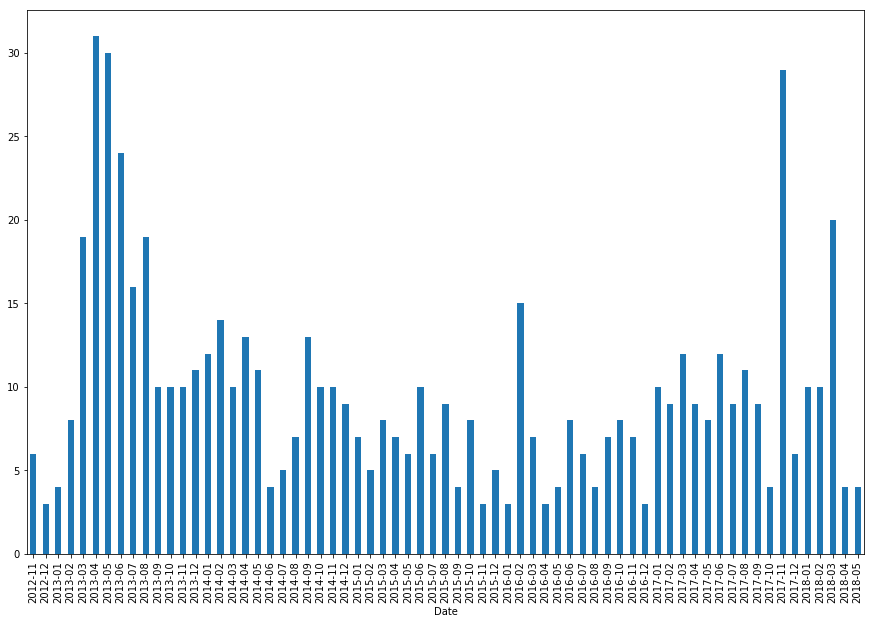

In [46]:
sql = "SELECT closed_at FROM requests_for_permissions ORDER BY closed_at"
result = cursor.execute(sql)

requests = {}
for item in result:
    if item[0] is not None and item[0] != '':
        date = re.sub(date_re, '', item[0])
        if date in requests:
            requests[date] += 1
        else:
            requests[date] = 1

s = pd.Series(requests, name='DateValue')
s.index.name = 'Date'
s.reset_index()
s.plot(figsize=(15,10), kind='bar')

### Number of successful request  for permission over time

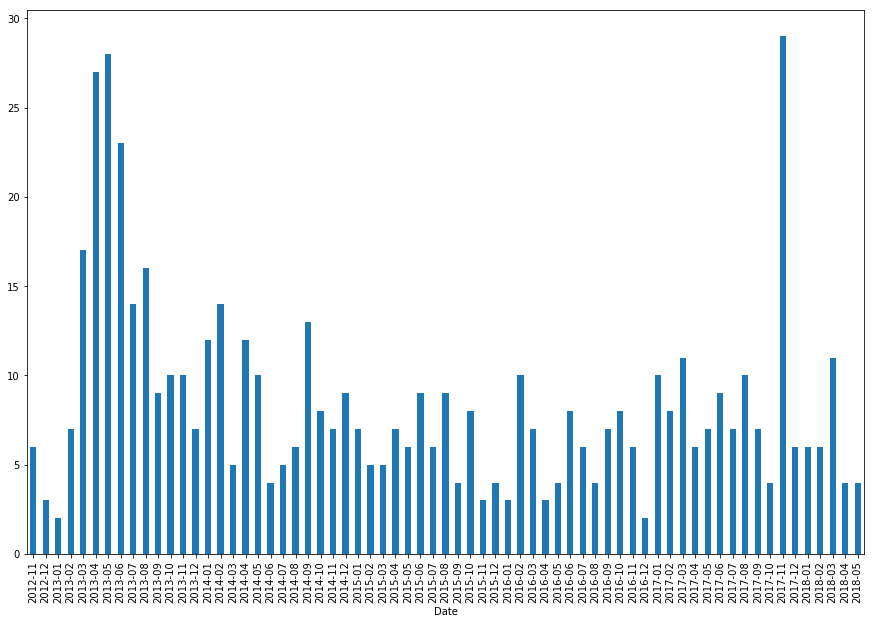

In [47]:
sql = "SELECT closed_at FROM requests_for_permissions WHERE is_successful = 1 ORDER BY closed_at"
result = cursor.execute(sql)

requests = {}
for item in result:
    if item[0] is not None and item[0] != '':
        date = re.sub(date_re, '', item[0])
        if date in requests:
            requests[date] += 1
        else:
            requests[date] = 1

s = pd.Series(requests, name='DateValue')
s.index.name = 'Date'
s.reset_index()
s.plot(figsize=(15,10), kind='bar')

### Number of unsuccessful request  for permission over time

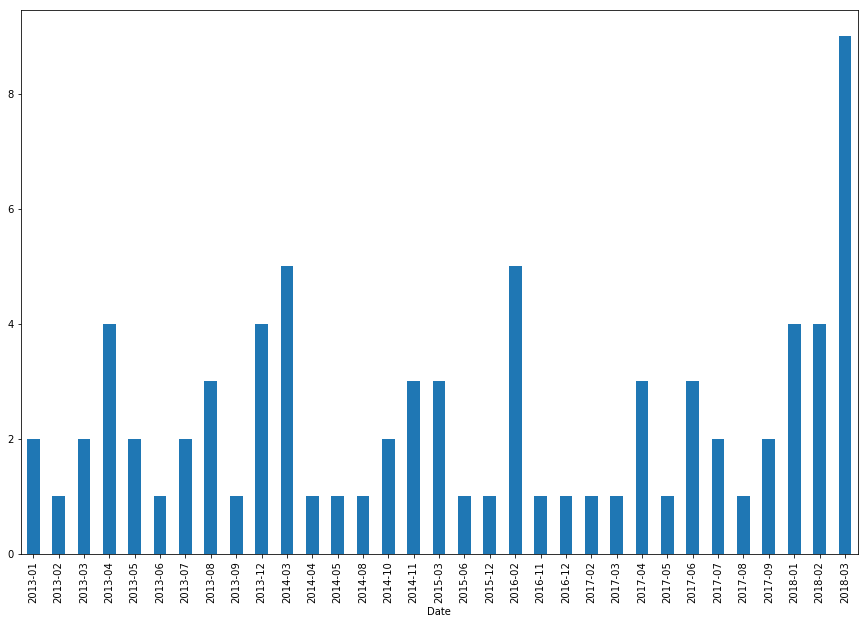

In [48]:
sql = "SELECT closed_at FROM requests_for_permissions WHERE is_successful = 0 ORDER BY closed_at"
result = cursor.execute(sql)

requests = {}
for item in result:
    if item[0] is not None and item[0] != '':
        date = re.sub(date_re, '', item[0])
        if date in requests:
            requests[date] += 1
        else:
            requests[date] = 1

s = pd.Series(requests, name='DateValue')
s.index.name = 'Date'
s.reset_index()
s.plot(figsize=(15,10), kind='bar')

### Distribution of editor count per request for permission

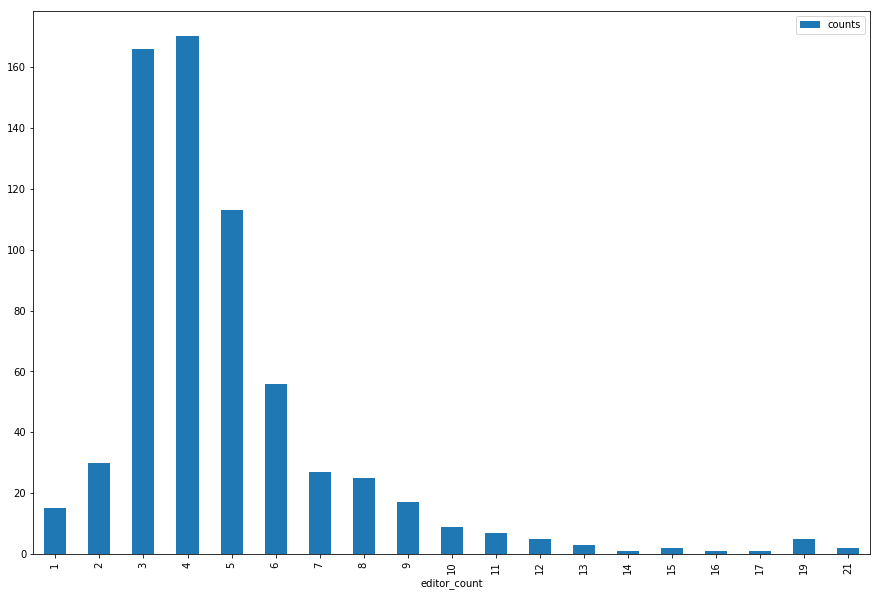

In [66]:
sql = "SELECT editor_count FROM requests_for_permissions"
result = cursor.execute(sql)

edit_count = {'editor_count': []}
for item in result:
    edit_count['editor_count'].append(item[0])

df = pd.DataFrame(edit_count)
df = df.groupby(['editor_count']).size().reset_index(name='counts')
df.plot(x='editor_count', y='counts', figsize=(15,10), kind='bar')

#s = pd.Series(requests, name='DateValue')
#s.index.name = 'Date'
#s.reset_index()
#s.plot(figsize=(15,10), kind='bar')